# 필요 라이브러리

In [66]:
pip install keras

In [67]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [68]:
pip install xgboost

In [69]:
pip install lightgbm

In [75]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM, SimpleRNN, GRU

import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import font_manager, rc
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn import preprocessing

# 필요 함수 정의

In [87]:
# 라인그래프
def line_graph(df):
    cols=df.columns

    # 캔버스생성
    fig = plt.figure(figsize=(30, 10)) # 캔버스 생성
    fig.set_facecolor('white') # 캔버스 색상 설정

    # 그림 뼈대(프레임) 생성
    ax = fig.add_subplot() 
    ax.set_xlabel("날짜",fontsize=20)
    ax.set_ylabel(cols[0]+"+"+cols[1],fontsize=20)

    # 데이터추가
    for col in df.columns:
        ax.plot(df[col],label=col)

    plt.legend(fontsize=10) #범례
    plt.title(cols[0]+"+"+cols[1],fontsize=35) # 타이틀설정

    plt.grid()
    plt.show() 

# 예측하기
def my_predict(x,y,my_model,predict_size):
    predL=[]
    tempX=np.concatenate((x[-1][1:],np.array([y[-1]])),axis=0)
    
    for i in range(predict_size):
        tempY=my_model.predict(np.array([tempX]))
        predL.append(list(tempY[0]))
        tempX=np.concatenate((tempX[1:],tempY),axis=0)
        
    return predL

# 두개 컬럼일때 전처리
def concat_preprocess(df1,col1,df2,col2):
    df1_x_train,df1_y_train,df1_x_val,df1_y_val=preprocess(df1,col1)
    df2_x_train,df2_y_train,df2_x_val,df2_y_val=preprocess(df2,col2)

    # train
    size=len(df1_x_train)
    con_x_train=[]
    con_y_train=[]

    for i in range(size):
        con_x_train.append(np.concatenate((df1_x_train[i],df2_x_train[i]),axis=1))
    con_y_train=np.concatenate((df1_y_train,df2_y_train),axis=1)

    con_x_train=np.array(con_x_train)
    con_y_train=np.array(con_y_train)

    print(con_x_train.shape)
    print(con_y_train.shape)

    # val
    size=len(df1_x_val)
    con_x_val=[]
    con_y_val=[]

    for i in range(size):
        con_x_val.append(np.concatenate((df1_x_val[i],df2_x_val[i]),axis=1))
    con_y_val=np.concatenate((df1_y_val,df2_y_val),axis=1)

    con_x_val=np.array(con_x_val)
    con_y_val=np.array(con_y_val)

    return con_x_train,con_y_train,con_x_val,con_y_val

# 손실함수
def mse(L1,L2):
    size=len(L1)
    loss=0
    for i in range(size):
        loss+=(L1[i][0]-L2[i][0])**2
    return loss/size

# 하나의 컬럼일때 전처리
def preprocess(df,col):
    d=np.array(df[col])

    x,y=[],[]
    sequence=7
    size=len(d)

    for i in range(size-sequence):
        x.append(np.array(d[i:i+sequence]))
        y.append(np.array(d[i+sequence]))

    x=np.array(x)
    y=np.array(y)

    # data split
    splitPoint=int(len(x)*0.7)
    x_train=x[:splitPoint]
    x_val=x[splitPoint:]

    y_train=y[:splitPoint]
    y_val=y[splitPoint:]
    
    
    x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    y_train=y_train.reshape(y_train.shape[0],1)
    
    x_val=x_val.reshape(x_val.shape[0],x_val.shape[1],1)
    y_val=y_val.reshape(y_val.shape[0],1)
    
    return x_train,y_train,x_val,y_val

# 모델링
def model_dl(myModel,x,y,myEpoch):
    #hyper parameter
    sequence=7
    dropout=0.3
    epoch=myEpoch
    batch_size=14
    verbose=1
    
    model = Sequential()
    model.add(myModel(14, input_shape=(x.shape[1], x.shape[2]), activation='relu', return_sequences=True))
    model.add(Dropout(dropout)) 
    model.add(myModel(7, activation="relu", return_sequences=False))
    model.add(Dropout(dropout)) 
    model.add(Dense(y.shape[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')

    hist = model.fit(x, y, batch_size=batch_size, epochs=epoch, verbose=verbose)

    return model,hist

# 스케일링
def scaling(df):
    columns=df.columns    
    for col in columns[1:]:
        scaler = preprocessing.MinMaxScaler()
        reshaped=np.array(df[col]).reshape(-1,1)
        
        scaler_fit = scaler.fit(reshaped)
        result=scaler_fit.transform(reshaped)
        result=result.flatten()
        df[col]=result

    display(df)
    
# visualize
def visualize(myHist,title): 
    # 한글깨짐 방지
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
    fig, loss_ax = plt.subplots()

    plt.title(title,fontsize=15)
    loss_ax.plot(myHist.history['loss'], 'y', label='train loss')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')

    loss_ax.legend(loc='upper left')

    plt.show()

# 데이터 다운

In [85]:
pol_df=pd.read_csv("pollution_df.csv")
dc_df=pd.read_csv("dc_df.csv")

display(pol_df)
display(dc_df)

,측정일시,이산화질소농도(ppm),오존농도(ppm),이산화탄소농도(ppm),아황산가스(ppm),미세먼지(㎍/㎥),초미세먼지(㎍/㎥)
0,2016-01-01,0.049289,0.005211,0.981579,0.006079,70.736842,44.184211
1,2016-01-02,0.046237,0.008263,0.739474,0.006132,53.789474,31.210526
2,2016-01-03,0.051737,0.011737,0.947368,0.007289,98.861111,57.894737
3,2016-01-04,0.030077,0.022128,0.635897,0.006282,76.205128,45.076923
4,2016-01-05,0.029436,0.014744,0.453846,0.006051,34.333333,16.666667
...,...,...,...,...,...,...,...
1822,2020-12-27,0.039980,0.012900,0.790000,0.004040,65.000000,41.620000
1823,2020-12-28,0.049500,0.007560,0.860000,0.004000,61.580000,43.640000
1824,2020-12-29,0.035940,0.011040,0.868000,0.003640,67.520000,48.060000
1825,2020-12-30,0.013800,0.020880,0.410000,0.002800,33.600000,12.560000


,날짜,일교차
0,2016-01-01,7.3
1,2016-01-02,8.5
2,2016-01-03,4.3
3,2016-01-04,7.8
4,2016-01-05,6.3
...,...,...
1822,2020-12-27,8.6
1823,2020-12-28,7.2
1824,2020-12-29,10.5
1825,2020-12-30,6.7


In [86]:
# 스케일링
scaling(dc_df)
scaling(pol_df)

,날짜,일교차
0,2016-01-01,0.360248
1,2016-01-02,0.434783
2,2016-01-03,0.173913
3,2016-01-04,0.391304
4,2016-01-05,0.298137
...,...,...
1822,2020-12-27,0.440994
1823,2020-12-28,0.354037
1824,2020-12-29,0.559006
1825,2020-12-30,0.322981


,측정일시,이산화질소농도(ppm),오존농도(ppm),이산화탄소농도(ppm),아황산가스(ppm),미세먼지(㎍/㎥),초미세먼지(㎍/㎥)
0,2016-01-01,0.351666,0.068076,0.645776,0.653260,0.334218,0.306204
1,2016-01-02,0.329886,0.107959,0.486496,0.658916,0.247826,0.211403
2,2016-01-03,0.369127,0.153343,0.623269,0.783346,0.477586,0.406391
3,2016-01-04,0.214590,0.289106,0.418354,0.675086,0.362093,0.312728
4,2016-01-05,0.210016,0.192626,0.298583,0.650287,0.148645,0.105127
...,...,...,...,...,...,...,...
1822,2020-12-27,0.285245,0.168539,0.519737,0.434149,0.304973,0.287467
1823,2020-12-28,0.353168,0.098772,0.565789,0.429851,0.287539,0.302228
1824,2020-12-29,0.256421,0.144238,0.571053,0.391164,0.317820,0.334526
1825,2020-12-30,0.098459,0.272799,0.269737,0.300896,0.144907,0.075119


# 오염+일교차 모델 학습

이산화질소농도(ppm)
(1274, 7, 2)
(1274, 2)
<class 'keras.layers.recurrent_v2.LSTM'>
Epoch 1/100
91/91 [==============================] - 4s 4ms/step - loss: 0.1582
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0832
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0396
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0353
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0311
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0272
Epoch 7/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0254
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 9/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 10/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 11/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0212
Epoch 12/100
91/91 [=====================

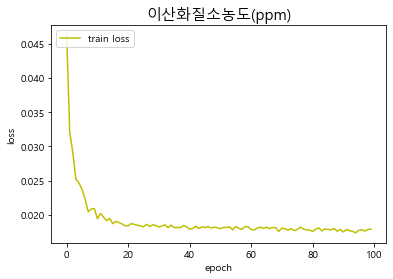

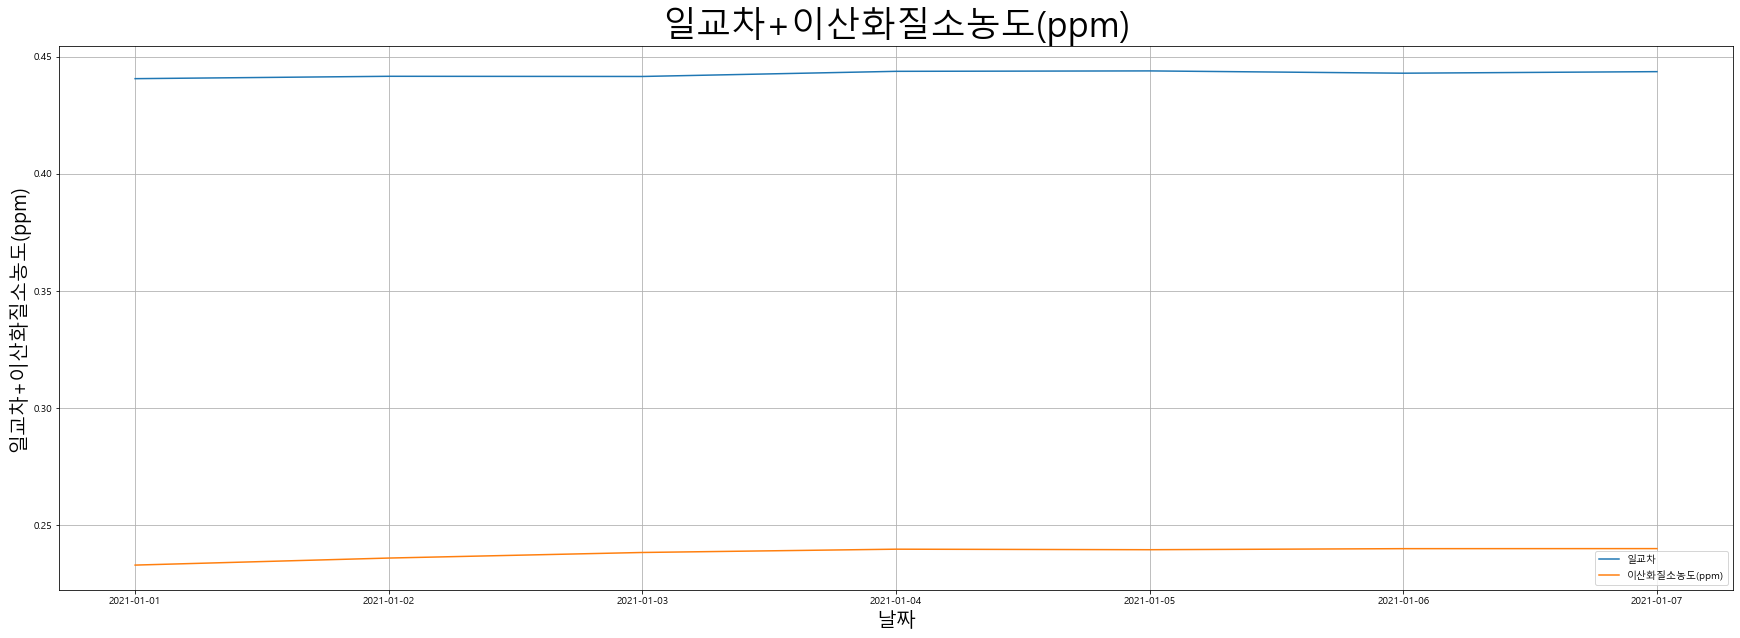

오존농도(ppm)
(1274, 7, 2)
(1274, 2)
<class 'keras.layers.recurrent_v2.LSTM'>
Epoch 1/100
91/91 [==============================] - 4s 4ms/step - loss: 0.1203
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0374
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0349
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0311
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0302
Epoch 7/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0295
Epoch 8/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 9/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0284
Epoch 10/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 11/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 12/100
91/91 [========================

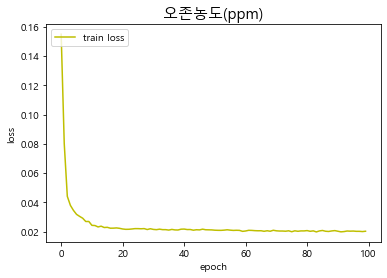

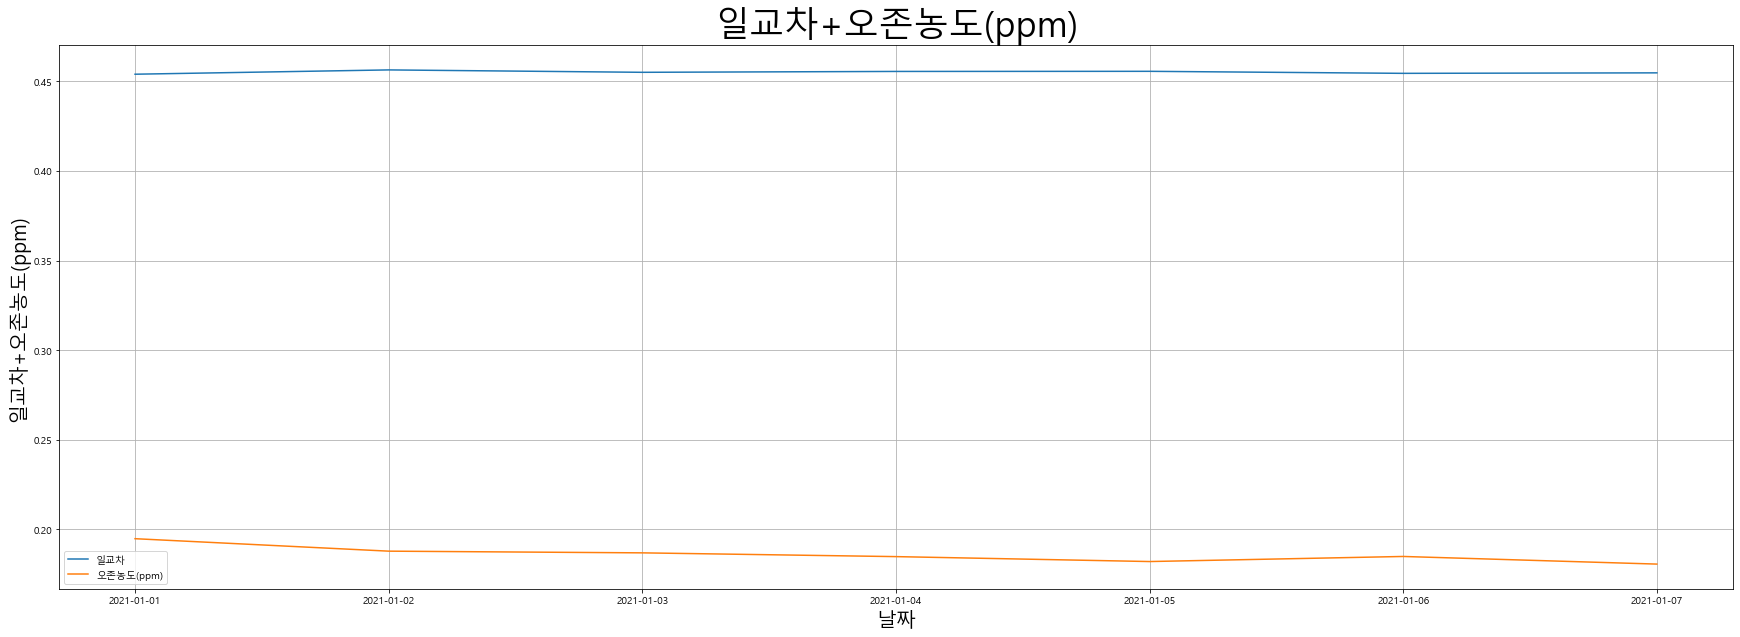

이산화탄소농도(ppm)
(1274, 7, 2)
(1274, 2)
<class 'keras.layers.recurrent_v2.LSTM'>
Epoch 1/100
91/91 [==============================] - 4s 4ms/step - loss: 0.1423
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0571
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0524
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0327
Epoch 7/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 8/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0276
Epoch 9/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 10/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 11/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 12/100
91/91 [=====================

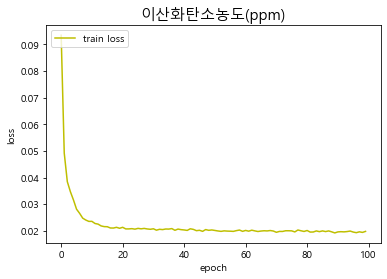

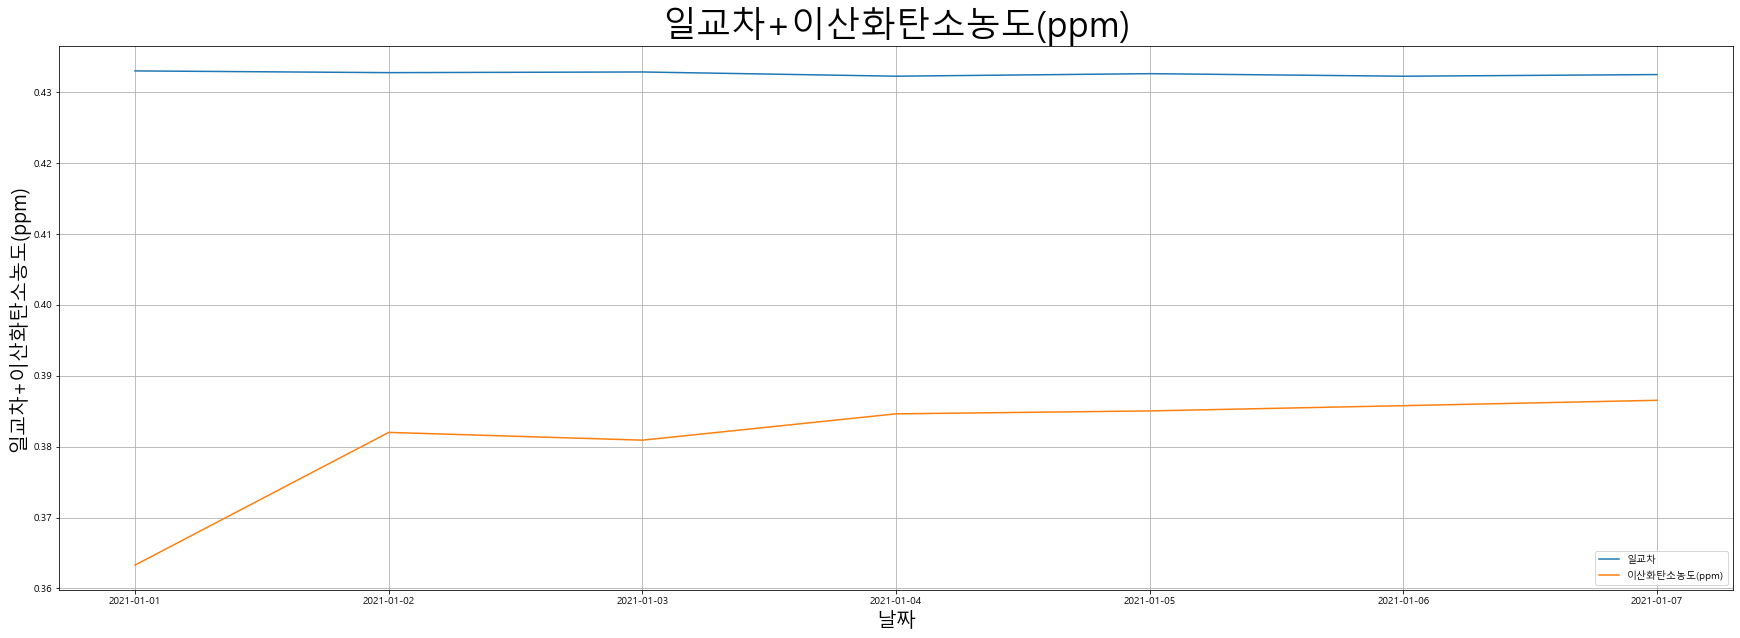

아황산가스(ppm)
(1274, 7, 2)
(1274, 2)
<class 'keras.layers.recurrent_v2.LSTM'>
Epoch 1/100
91/91 [==============================] - 4s 4ms/step - loss: 0.2202
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0553
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0426
Epoch 6/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 7/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 8/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0314
Epoch 9/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0321
Epoch 10/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0294
Epoch 11/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 12/100
91/91 [=======================

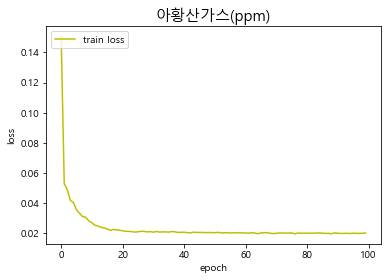

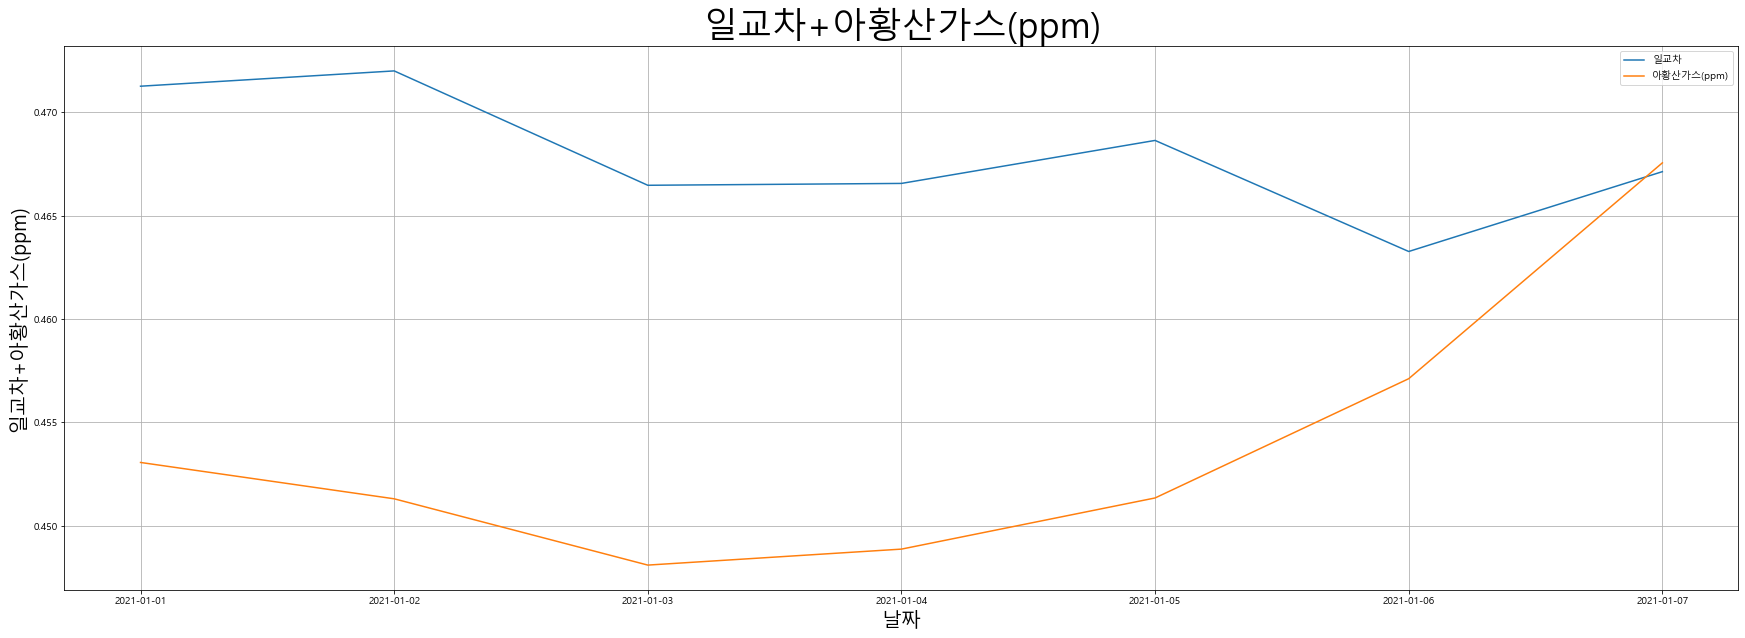

미세먼지(㎍/㎥)
(1274, 7, 2)
(1274, 2)
<class 'keras.layers.recurrent_v2.LSTM'>
Epoch 1/100
91/91 [==============================] - 4s 4ms/step - loss: 0.1167
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0393
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0347
Epoch 4/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0308
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0299
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0275
Epoch 7/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0266
Epoch 8/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0257
Epoch 9/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 10/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 11/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0237
Epoch 12/100
91/91 [========================

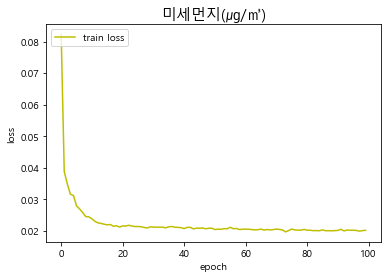

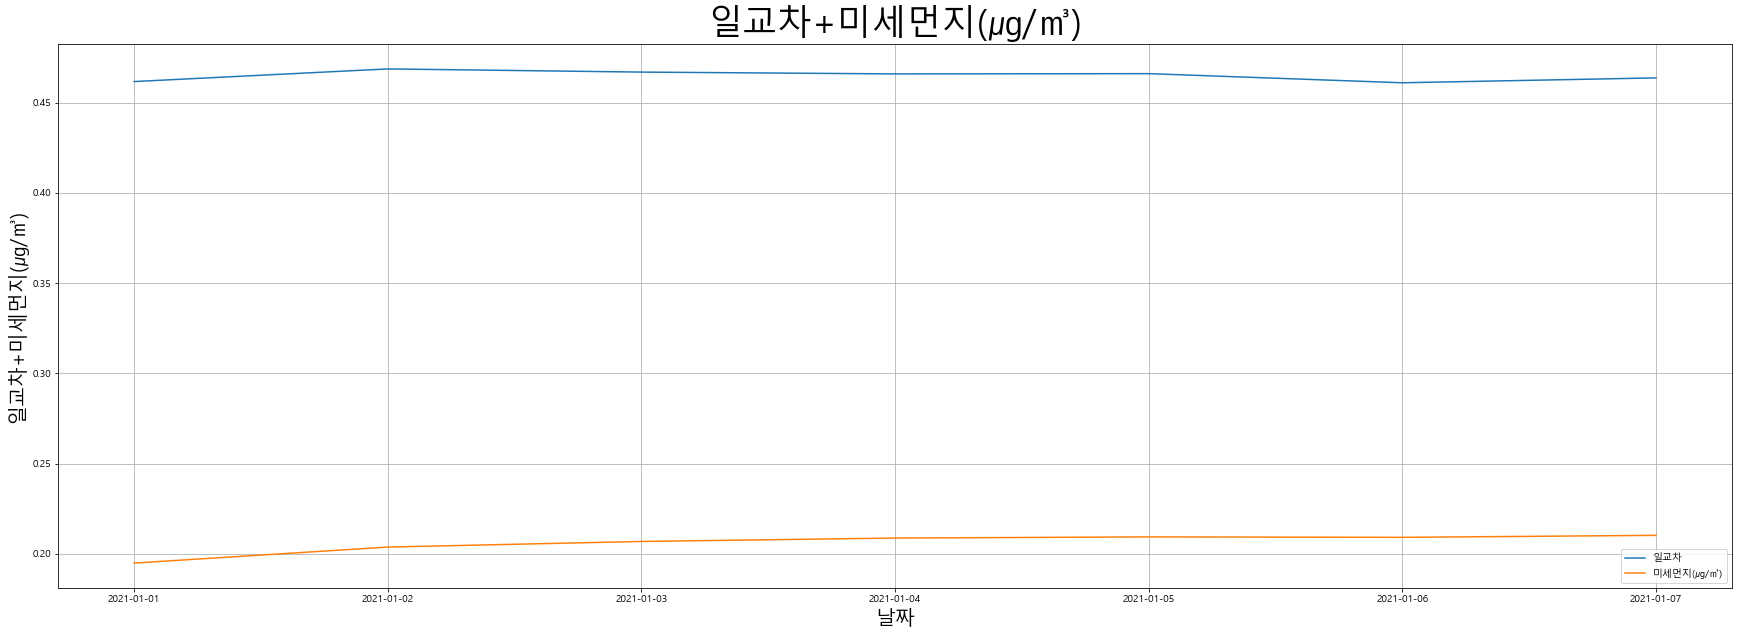

초미세먼지(㎍/㎥)
(1274, 7, 2)
(1274, 2)
<class 'keras.layers.recurrent_v2.LSTM'>
Epoch 1/100
91/91 [==============================] - 4s 4ms/step - loss: 0.1273
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0488
Epoch 3/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 6/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0280
Epoch 7/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 8/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0257
Epoch 9/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0244
Epoch 10/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 11/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 12/100
91/91 [=======================

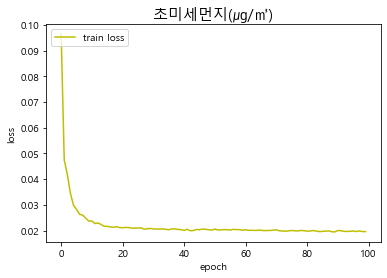

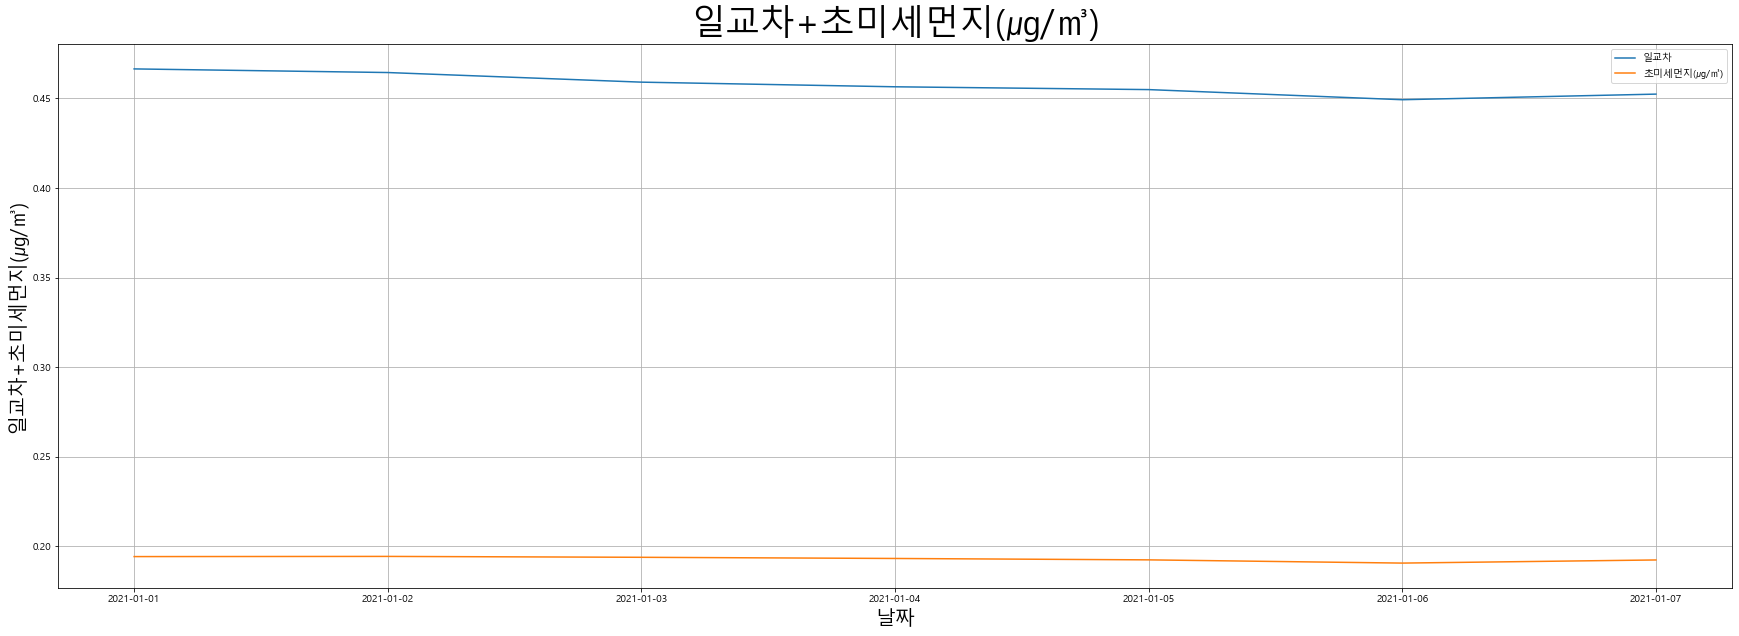

In [90]:
models=[LSTM, SimpleRNN, GRU]
modelNames=["LSTM","SimpleRnn","GRU"]
val_loss={}
pred_size=7

cols=pol_df.columns[1:]

for col in cols:    
    print(col)
    min_loss=math.inf
    
    # 전처리
    con_x_train,con_y_train,con_x_val,con_y_val=concat_preprocess(dc_df,"일교차",pol_df,col)
    
    # 딥러닝
    for i,model in enumerate(models):
        print(model)
        myModel,myHist=model_dl(model,con_x_train,con_y_train,100) #모델학습
        now_loss=myModel.evaluate(con_x_val,con_y_val) #loss평가
        
        # 최소 loss모델 선택
        if now_loss<min_loss:
            min_loss=now_loss
            min_model=myModel
            min_hist=myHist
            min_model_name=modelNames[i]
        # 모델별 loss 저장
        val_loss[modelNames[i]]=now_loss

    
    print(val_loss) # 각 모델별 loss
    print("선택 모델 :",min_model_name) # 최소 loss 모델
    print("val_loss",min_loss) # validation set loss
    
    visualize(min_hist,col) # 학습과정 시각화
    
    
        
    
    predL=my_predict(con_x_val,con_y_val,min_model,pred_size) # 최적 모델로 미래값 예측
    
    my_date=["2021-01-0"+str(i) for i in range(1,pred_size+1)]
    dc=[]
    pol=[]
    for i in range(pred_size):
        dc.append(predL[i][0])
        pol.append(predL[i][1])
        
    pred_df=pd.DataFrame({"날짜":my_date,"일교차":dc,col:pol})
    pred_df.set_index("날짜",inplace=True)
    line_graph(pred_df)
